# 1. Import Library

In [1]:
import cv2
import numpy as np
import os   # path processing
import xml.etree.ElementTree as ET #use for xml processing
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Function to detect Cell 

### Function: Remove Line

In [2]:
def removeLine(image, thresh):
# ========Begin remove line========
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(image, [c], -1, (255,255,255), 2)

    # Remove vertical
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(image, [c], -1, (255,255,255), 2)
    # ========End remove line========

### Function: Get annotations from .xml files 

In [3]:
#Draw bounded box from .xml data 
def getAnnotation(xml_path):
    tree = ET.parse(xml_path)

    root = tree.getroot()

    sample_annotations = []

    for neighbor in root.iter('bndbox'):
        xmin = int(neighbor.find('xmin').text)
        ymin = int(neighbor.find('ymin').text)
        xmax = int(neighbor.find('xmax').text)
        ymax = int(neighbor.find('ymax').text)

        sample_annotations.append((xmin, ymin, xmax, ymax))
    return sample_annotations

### Function: Calculate IoU and Draw in image

In [4]:
def drawIoUResult(img, sample_annotations,boundedBox):
    for bbox in sample_annotations:
        for bbox_pending in boundedBox:
            if (((bbox[0] <= bbox_pending[0]) and (bbox_pending[0] <= bbox[2]) and (bbox[1] <= bbox_pending[1]) and (bbox_pending[1] <= bbox[3])) or ((bbox_pending[0] <= bbox[2]) and (bbox[2] <= bbox_pending[2]) and (bbox_pending[1] <= bbox[1]) and (bbox[1] <= bbox_pending[3])) or ((bbox_pending[0] <= bbox[0]) and (bbox[0] <= bbox_pending[2]) and (bbox_pending[1] <= bbox[1]) and (bbox[1] <= bbox_pending[3])) or ((bbox[0] <= bbox_pending[2]) and (bbox_pending[2] <= bbox[2]) and (bbox[1] <= bbox_pending[1]) and (bbox_pending[1] <= bbox[3]))):
                #below are coordinates of interaction area
                x_left = max(bbox[0], bbox_pending[0])
                y_top = max(bbox[1], bbox_pending[1])
                x_right = min(bbox[2], bbox_pending[2])
                y_bottom = min(bbox[3], bbox_pending[3])
                # --

                intersection_area = (x_right - x_left) * (y_bottom - y_top)

                bbox_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

                bbox_pending_area =  (bbox_pending[2] - bbox_pending[0]) * (bbox_pending[3] - bbox_pending[1])

                iou = intersection_area / float(bbox_area  + bbox_pending_area - intersection_area)
                #print(iou) #print IoU of each cell
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
        iou = round(iou, 2)
        text = str(iou)
        cv2.putText(img, text, (bbox[0] - 4, bbox[3] + 4), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#         print("-------")


### Main Func: Detect cell in table

In [5]:
def tableDetection(img_path, xml_path):
    img = cv2.imread(img_path)
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    #remove line in table image
    removeLine(image, thresh)
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, img_bin) = cv2.threshold(img_gray, 188, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = cv2.bitwise_not(img_bin)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 30)) #kernel width on the left, kernal height on the right
    connected = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel)

#     cv2.imshow("connected", connected)
#     cv2.waitKey(0)
    contours, hierarchy = cv2.findContours(image=connected, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    (x1,y1,_) = img.shape
    cnt = 0
    boundedBox = []
    for contour in contours:
        # get rectangle bounding contour
        [x,y,w,h] = cv2.boundingRect(contour)
        boundedBox.append((x, y, x + w, y + h))
    #     discard areas that are too large
    #     if h>x1/4 and w>y1/4:
    #         continue

        # discard areas that are too small
        if h<4 or w<4:
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)
        cnt += 1 #number of cells detected
#     print("------------")
#     print(cnt)
   
    
    
    sample_annotations= getAnnotation(xml_path)
    drawIoUResult(img, sample_annotations,boundedBox)
    
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.show()
    

# 3. Run  

### Get image and annotation from forms and detect cell

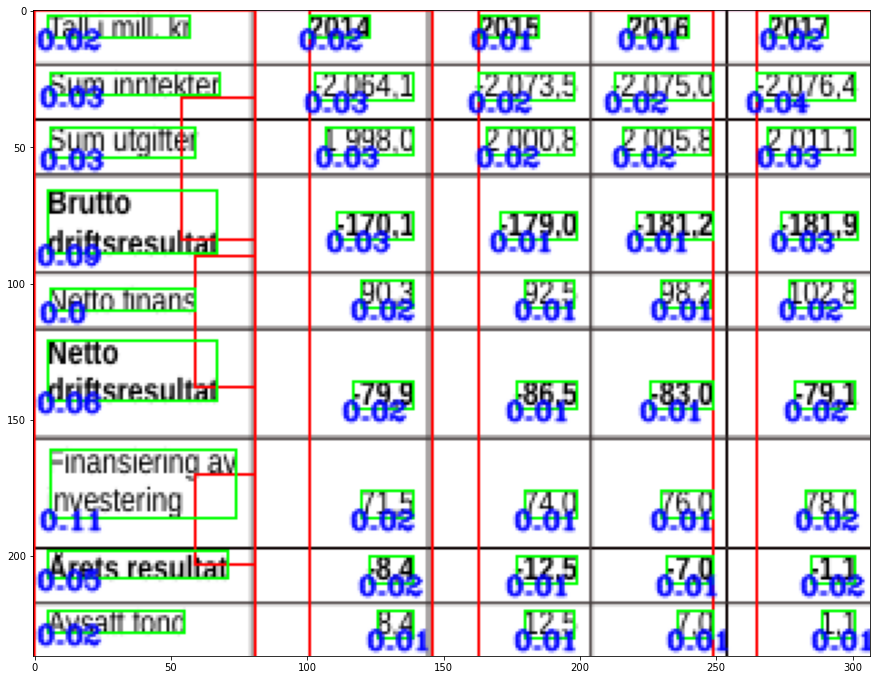

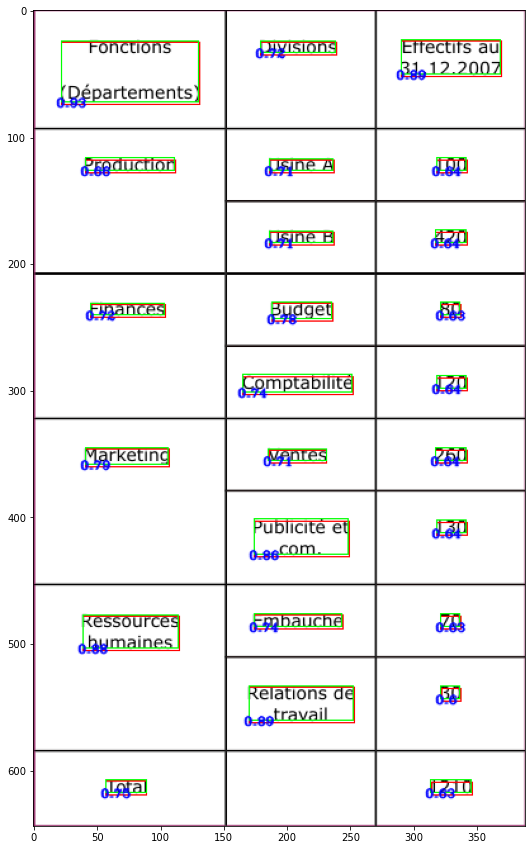

In [6]:
for i in os.listdir('./forms/'): #image store in "forms" folder
    if i.endswith('.png') or i.endswith('.PNG') or i.endswith('.jpg') or i.endswith('.JPG'):
        tableDetection(os.path.splitext('./forms/' + i)[0] + '.png', os.path.splitext('./forms/' + i)[0] + '.xml') # os.path.splitext use for split file name out of extension
